# Gesture Recognition
A project that will be able to predict the 5 gestures correctly.

In [1]:
import numpy as np
import os
from skimage.transform import resize
from matplotlib.pyplot import imread
import datetime
import tensorflow as tf
from PIL import Image
import os
from tensorflow.keras.utils import to_categorical

We set the random seed so that the results don't vary drastically.

In [2]:

import random as random

from keras import backend as K
import tensorflow as tf
import pathlib
import glob
from keras.models import Sequential, Model
from keras.layers import Dense, GRU, Flatten, TimeDistributed, Flatten, BatchNormalization, Activation,Dropout
from keras.layers.convolutional import Conv3D, MaxPooling3D
from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau
from keras import optimizers,regularizers


In [3]:
from google.colab import drive
# This will prompt for authorization.
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
#!unzip -u "/content/drive/MyDrive/Project_data.zip" -d "/content/drive/MyDrive/Project_data"

In [5]:
image_dir_train = pathlib.Path("/content/drive/MyDrive/Project_data/Project_data/train")
image_dir_test = pathlib.Path('/content/drive/MyDrive/Project_data/Project_data/val')
source_path          = "/content/drive/MyDrive/Project_data/Project_data/"

train_doc = np.random.permutation(open(source_path+'train.csv').readlines())
val_doc = np.random.permutation(open(source_path+'val.csv').readlines())

In [6]:
os.environ['TF_FORCE_GPU_ALLOW_GROWTH'] = 'true'
#image_count_train = len(list(image_dir_train.glob('*/*.png')))
#print(image_count_train)
#image_count_test = len(list(image_dir_test.glob('*/*.png')))
#print(image_count_test)

In [7]:
curr_dt_time = datetime.datetime.now()
train_path = "/content/drive/MyDrive/Project_data/Project_data/train"
test_path = '/content/drive/MyDrive/Project_data/Project_data/val'
num_train_sequences = len(train_doc)
print('# training sequences =', num_train_sequences)
num_val_sequences = len(val_doc)

# training sequences = 663


In this block, you read the folder names for training and validation. You also set the `batch_size` here. Note that you set the batch size in such a way that you are able to use the GPU in full capacity. You keep increasing the batch size until the machine throws an error.

## Generator


In [8]:
import time
def generator(source_path, folder_list, batch_size,random_img):
    print( 'Source path = ', source_path, '; batch size =', batch_size)
    if random_img==1:
        img_idx = list(random.sample(range(0,30),num_imges))
    else:
        img_idx = list(range(num_imges))   
    while True:
        t = np.random.permutation(folder_list)
        #t=np.random.shuffle(folder_list)
        num_batches = len(folder_list)//batch_size
        for batch in range(num_batches): # we iterate over the number of batches
            time.sleep(0.1)
            batch_data = np.zeros((batch_size,len(img_idx),120,160,3)) # x is the number of images you use for each video, (y,z) is the final size of the input images and 3 is the number of channels RGB
            batch_labels = np.zeros((batch_size,5)) # batch_labels is the one hot representation of the output
            for folder in range(batch_size): # iterate over the batch_size
                #print(batch,folder,(folder + (batch*batch_size)))
                imgs = os.listdir(source_path+'/'+ t[folder + (batch*batch_size)].split(';')[0]) # read all the images in the folder
                for idx,item in enumerate(img_idx): #  Iterate iver the frames/images of a folder to read them in
                    image = Image.open((source_path+'/'+ t[folder + (batch*batch_size)].split(';')[0]+'/'+imgs[item]))
                    shap0,shap1,shap2=np.array(image).shape
                    if shap0==360 and shap1==360:
                        area=(15,80,355,340)  #for 240*320(20,100,360,340)
                        image=(np.array(image.crop(area)))
                        image = np.resize(image,(120, 160,3))
                    else:
                        image=(np.array(image))
                        image = np.resize(image,(120, 160,3))
                    #crop the images and resize them. Note that the images are of 2 different shape 
                    #and the conv3D will throw error if the inputs in a batch have different shapes
                    
                    batch_data[folder,idx,:,:,0] = image[:,:,0]/255.0
                    batch_data[folder,idx,:,:,1] = image[:,:,1]/255.0
                    batch_data[folder,idx,:,:,2] = image[:,:,2]/255.0
                    
                batch_labels[folder, int(t[folder + (batch*batch_size)].split(';')[2])] = 1
                
                #batch_labels = tf.keras.utils.to_categorical(batch_labels, 5)
            yield batch_data, batch_labels #you yield the batch_data and the batch_labels, remember what does yield do

        
        # write the code for the remaining data points which are left after full batches
        # I have used all of training data by using batch size in mutiple of 663.(batchsize available:3,13,17,39,51,221:=range is distributed)
        #For validation data only few folders were left out. (I will learn it,incase if someday it makes much difference as loosing training data:)



In [9]:
import matplotlib.pyplot as plt

def steps(batch_size):
  if (num_train_sequences%batch_size) == 0:
      steps_per_epoch = int(num_train_sequences/batch_size)
  else:
      steps_per_epoch = (num_train_sequences//batch_size) + 1

  if (num_val_sequences%batch_size) == 0:
      validation_steps = int(num_val_sequences/batch_size)
  else:
      validation_steps = (num_val_sequences//batch_size) + 1    
  return steps_per_epoch,validation_steps

def plot_history(history):   
   val_acc = history.history['val_categorical_accuracy']
   acc = history.history['categorical_accuracy']
   loss = history.history['loss']
   val_loss = history.history['val_loss']

   epochs_range = range(num_epochs)
 
   plt.figure(figsize=(8, 8))
   plt.subplot(1, 2, 1)
   plt.plot(epochs_range, acc, label='Training Accuracy')
   plt.plot(epochs_range, val_acc, label='Validation Accuracy')
   plt.legend(loc='lower right')
   plt.title('Training and Validation Accuracy')
 
   plt.subplot(1, 2, 2)
   plt.plot(epochs_range, loss, label='Training Loss')
   plt.plot(epochs_range, val_loss, label='Validation Loss')
   plt.legend(loc='upper right')
   plt.title('Training and Validation Loss')
   return plt.show()

#Model 1
Trying to overfit on small data and 2 convolution layers
 : Fixed learning rate=0.01


HyperParameters

In [ ]:
batch_size = 3
num_imges=3       #per_folder
num_epochs=12
input_shape=[num_imges,120,160,3]
print ("Batch_size=",batch_size,"\n   epochs =", num_epochs)

Batch_size= 3 
   epochs = 12


Objective:
Trying to overfit on small values of hyperparameter

In [ ]:
model = Sequential()
model.add(Conv3D(32, kernel_size=(3, 3, 3), activation='relu', input_shape=input_shape,padding="same"))
model.add(Conv3D(32, kernel_size=(2, 2, 2), activation='relu',padding="same"))
model.add(BatchNormalization())
model.add(MaxPooling3D(pool_size=(2, 2, 2)))
model.add(Dropout(0.35))
model.add(Flatten())
model.add(Dense(256, activation='relu'))
model.add(Dense(5, activation='softmax') )

In [ ]:
model.compile(optimizer=tf.keras.optimizers.Adadelta(learning_rate=0.01),
              loss=tf.keras.losses.categorical_crossentropy,
              metrics=[tf.keras.metrics.CategoricalAccuracy()])
print (model.summary())

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv3d (Conv3D)             (None, 3, 120, 160, 32)   2624      
                                                                 
 conv3d_1 (Conv3D)           (None, 3, 120, 160, 32)   8224      
                                                                 
 batch_normalization (BatchN  (None, 3, 120, 160, 32)  128       
 ormalization)                                                   
                                                                 
 max_pooling3d (MaxPooling3D  (None, 1, 60, 80, 32)    0         
 )                                                               
                                                                 
 dropout (Dropout)           (None, 1, 60, 80, 32)     0         
                                                                 
 flatten (Flatten)           (None, 153600)            0

In [ ]:
train_generator = generator(train_path, train_doc, batch_size,0)
val_generator = generator(test_path, val_doc, batch_size,0)

In [ ]:
if (num_train_sequences%batch_size) == 0:
    steps_per_epoch = int(num_train_sequences/batch_size)
else:
    steps_per_epoch = (num_train_sequences//batch_size) + 1

if (num_val_sequences%batch_size) == 0:
    validation_steps = int(num_val_sequences/batch_size)
else:
    validation_steps = (num_val_sequences//batch_size) + 1

In [ ]:
history=model.fit(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1, 
                    validation_data=val_generator,
                    validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)

Source path =  /content/drive/MyDrive/Project_data/Project_data/train ; batch size = 3
Epoch 1/12
221/221 [==============================] - 825s 4s/step - loss: 1.9247 - categorical_accuracy: 0.3363 - val_loss: 1.5074 - val_categorical_accuracy: 0.3627
Epoch 2/12
221/221 [==============================] - 350s 2s/step - loss: 1.3479 - categorical_accuracy: 0.4796 - val_loss: 1.3138 - val_categorical_accuracy: 0.5294
Epoch 3/12
221/221 [==============================] - 347s 2s/step - loss: 1.0485 - categorical_accuracy: 0.6094 - val_loss: 1.2690 - val_categorical_accuracy: 0.4902
Epoch 4/12
221/221 [==============================] - 349s 2s/step - loss: 0.8422 - categorical_accuracy: 0.6817 - val_loss: 1.8635 - val_categorical_accuracy: 0.4118
Epoch 5/12
221/221 [==============================] - 367s 2s/step - loss: 0.6502 - categorical_accuracy: 0.7632 - val_loss: 1.3857 - val_categorical_accuracy: 0.5784
Epoch 6/12
221/221 [==============================] - 347s 2s/step - loss: 0.4

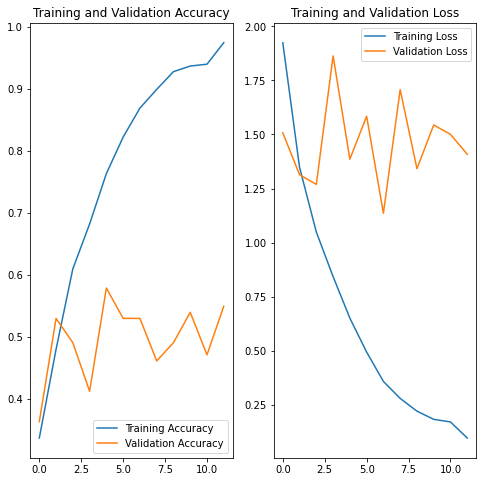

In [ ]:
plot_history(history)

In [ ]:
tf.keras.backend.clear_session()

#Model 2
Using random set of images from each folder every time.
So model can utilise whole data
To not train on same images again and again: using lesser number of epochs<20 
: Fixed learning rate=0.01

HpyerParameters

In [ ]:
batch_size = 3
num_imges=3       #per_folder
num_epochs=12
input_shape=[num_imges,120,160,3]
print ("Batch_size=",batch_size,"\n   epochs =", num_epochs)

Batch_size= 3 
   epochs = 12


In [ ]:
model = Sequential()
model.add(Conv3D(32, kernel_size=(3, 3, 3), activation='relu', input_shape=input_shape,padding="same"))
model.add(Conv3D(32, kernel_size=(2, 2, 2), activation='relu',padding="same"))
model.add(BatchNormalization())
model.add(MaxPooling3D(pool_size=(2, 2, 2)))
model.add(Dropout(0.35))
model.add(Flatten())
model.add(Dense(256, activation='relu'))
model.add(Dense(5, activation='softmax') )

model.compile(optimizer=tf.keras.optimizers.Adadelta(learning_rate=0.01),
              loss=tf.keras.losses.categorical_crossentropy,
              metrics=[tf.keras.metrics.CategoricalAccuracy()])
print (model.summary())


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv3d (Conv3D)             (None, 3, 120, 160, 32)   2624      
                                                                 
 conv3d_1 (Conv3D)           (None, 3, 120, 160, 32)   8224      
                                                                 
 batch_normalization (BatchN  (None, 3, 120, 160, 32)  128       
 ormalization)                                                   
                                                                 
 max_pooling3d (MaxPooling3D  (None, 1, 60, 80, 32)    0         
 )                                                               
                                                                 
 dropout (Dropout)           (None, 1, 60, 80, 32)     0         
                                                                 
 flatten (Flatten)           (None, 153600)            0

In [ ]:
train_generator = generator(train_path, train_doc, batch_size,1)
val_generator = generator(test_path, val_doc, batch_size,1)

In [ ]:
if (num_train_sequences%batch_size) == 0:
    steps_per_epoch = int(num_train_sequences/batch_size)
else:
    steps_per_epoch = (num_train_sequences//batch_size) + 1

if (num_val_sequences%batch_size) == 0:
    validation_steps = int(num_val_sequences/batch_size)
else:
    validation_steps = (num_val_sequences//batch_size) + 1

In [ ]:
history=model.fit(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1, 
                    validation_data=val_generator,
                    validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)

Source path =  /content/drive/MyDrive/Project_data/Project_data/train ; batch size = 3
Epoch 1/12
221/221 [==============================] - 623s 3s/step - loss: 1.9217 - categorical_accuracy: 0.3062 - val_loss: 1.5170 - val_categorical_accuracy: 0.3235
Epoch 2/12
221/221 [==============================] - 354s 2s/step - loss: 1.2322 - categorical_accuracy: 0.5053 - val_loss: 1.4158 - val_categorical_accuracy: 0.3922
Epoch 3/12
221/221 [==============================] - 362s 2s/step - loss: 0.9247 - categorical_accuracy: 0.6606 - val_loss: 1.2735 - val_categorical_accuracy: 0.5098
Epoch 4/12
221/221 [==============================] - 361s 2s/step - loss: 0.7117 - categorical_accuracy: 0.7330 - val_loss: 1.2814 - val_categorical_accuracy: 0.5000
Epoch 5/12
221/221 [==============================] - 359s 2s/step - loss: 0.4953 - categorical_accuracy: 0.8265 - val_loss: 1.4996 - val_categorical_accuracy: 0.5196
Epoch 6/12
221/221 [==============================] - 357s 2s/step - loss: 0.3

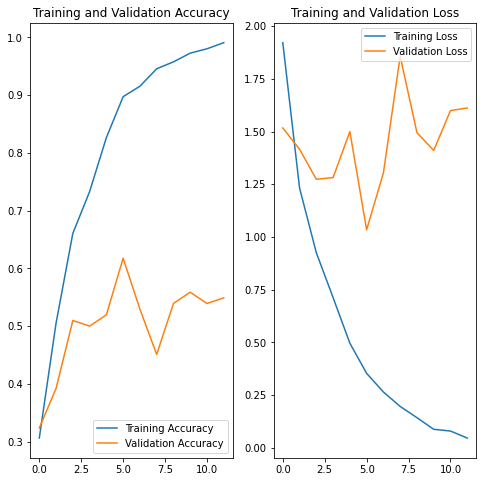

In [ ]:
plot_history(history)

In [ ]:
tf.keras.backend.clear_session()

#Model 3
Decay learning rate on val_loss (ReduceOnPlateau)


Hyper Parameters

In [ ]:
batch_size = 3
num_imges=3       #per_folder
num_epochs=12
input_shape=[num_imges,120,160,3]
print ("Batch_size=",batch_size,"\n   epochs =", num_epochs)

Batch_size= 3 
   epochs = 12


In [ ]:
model = Sequential()
model.add(Conv3D(32, kernel_size=(3, 3, 3), activation='relu', input_shape=input_shape,padding="same"))
model.add(Conv3D(32, kernel_size=(2, 2, 2), activation='relu',padding="same"))
model.add(BatchNormalization())
model.add(MaxPooling3D(pool_size=(2, 2, 2)))
model.add(Dropout(0.35))
model.add(Flatten())
model.add(Dense(256, activation='relu'))
model.add(Dense(5, activation='softmax') )

model.compile(optimizer=tf.keras.optimizers.Adadelta(learning_rate=0.01),
              loss=tf.keras.losses.categorical_crossentropy,
              metrics=[tf.keras.metrics.CategoricalAccuracy()])
print (model.summary())


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv3d (Conv3D)             (None, 3, 120, 160, 32)   2624      
                                                                 
 conv3d_1 (Conv3D)           (None, 3, 120, 160, 32)   8224      
                                                                 
 batch_normalization (BatchN  (None, 3, 120, 160, 32)  128       
 ormalization)                                                   
                                                                 
 max_pooling3d (MaxPooling3D  (None, 1, 60, 80, 32)    0         
 )                                                               
                                                                 
 dropout (Dropout)           (None, 1, 60, 80, 32)     0         
                                                                 
 flatten (Flatten)           (None, 153600)            0

In [ ]:
train_generator = generator(train_path, train_doc, batch_size,1)
val_generator = generator(test_path, val_doc, batch_size,1)

In [ ]:
if (num_train_sequences%batch_size) == 0:
    steps_per_epoch = int(num_train_sequences/batch_size)
else:
    steps_per_epoch = (num_train_sequences//batch_size) + 1

if (num_val_sequences%batch_size) == 0:
    validation_steps = int(num_val_sequences/batch_size)
else:
    validation_steps = (num_val_sequences//batch_size) + 1

In [ ]:
LR = ReduceLROnPlateau(monitor='val_loss', factor=0.1,patience=1, min_lr=0.0001)
callbacks_list = [LR]

In [ ]:
history=model.fit(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1, 
                    validation_data=val_generator, callbacks=callbacks_list,
                    validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)

Source path =  /content/drive/MyDrive/Project_data/Project_data/train ; batch size = 3
Epoch 1/12
221/221 [==============================] - 791s 4s/step - loss: 1.9259 - categorical_accuracy: 0.3107 - val_loss: 1.5236 - val_categorical_accuracy: 0.3039 - lr: 0.0100
Epoch 2/12
221/221 [==============================] - 39s 175ms/step - loss: 1.2581 - categorical_accuracy: 0.5098 - val_loss: 1.3038 - val_categorical_accuracy: 0.4510 - lr: 0.0100
Epoch 3/12
221/221 [==============================] - 38s 173ms/step - loss: 0.9408 - categorical_accuracy: 0.6320 - val_loss: 1.3030 - val_categorical_accuracy: 0.5294 - lr: 0.0100
Epoch 4/12
221/221 [==============================] - 38s 173ms/step - loss: 0.7305 - categorical_accuracy: 0.7421 - val_loss: 1.3957 - val_categorical_accuracy: 0.4510 - lr: 0.0100
Epoch 5/12
221/221 [==============================] - 38s 173ms/step - loss: 0.3860 - categorical_accuracy: 0.8763 - val_loss: 1.1020 - val_categorical_accuracy: 0.5980 - lr: 1.0000e-03
E

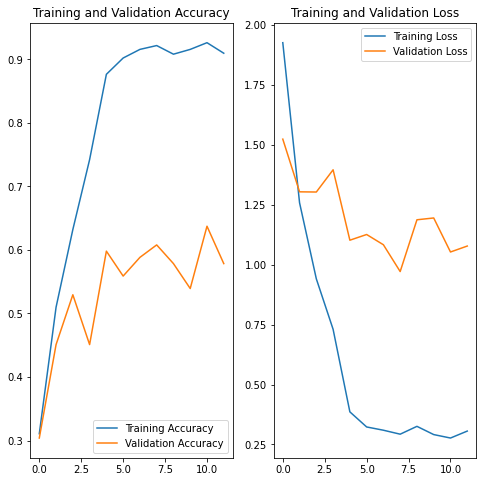

In [ ]:
plot_history(history)

In [ ]:
#So far we have achieved hyper-parameters that make val_loss decrease and increase the accuracy

In [ ]:
tf.keras.backend.clear_session()

#Model 4
###Increasing Batch size and regulaiser to control overfitting on given data

In [ ]:
#Hyper Parameters
batch_size = 13
num_imges=5       #increasing images per_folder
num_epochs=12
input_shape=[num_imges,120,160,3]
print ("Batch_size=",batch_size,"\n   epochs =", num_epochs)

Batch_size= 13 
   epochs = 12


In [ ]:
#Training Model
model = Sequential()
model.add(Conv3D(64, kernel_size=(3, 3, 3), activation='relu', input_shape=input_shape,padding="same",kernel_regularizer=regularizers.l2(l=0.01)))
model.add(Conv3D(64, kernel_size=(2, 2, 2), activation='relu',padding="same",kernel_regularizer=regularizers.l2(l=0.01)))
model.add(BatchNormalization())
model.add(MaxPooling3D(pool_size=(2, 2, 2)))
model.add(Dropout(0.35))
model.add(Flatten())
model.add(Dense(256, activation='relu'))
model.add(Dense(5, activation='softmax') )

Now that you have written the model, the next step is to `compile` the model. When you print the `summary` of the model, you'll see the total number of parameters you have to train.

In [ ]:
#Optimising Model with loss function and other metrics
model.compile(optimizer=tf.keras.optimizers.Adadelta(learning_rate=0.1),
              loss=tf.keras.losses.categorical_crossentropy,
              metrics=[tf.keras.metrics.CategoricalAccuracy()])
print (model.summary())

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv3d_2 (Conv3D)           (None, 5, 120, 160, 64)   5248      
                                                                 
 conv3d_3 (Conv3D)           (None, 5, 120, 160, 64)   32832     
                                                                 
 batch_normalization_1 (Batc  (None, 5, 120, 160, 64)  256       
 hNormalization)                                                 
                                                                 
 max_pooling3d_1 (MaxPooling  (None, 2, 60, 80, 64)    0         
 3D)                                                             
                                                                 
 dropout_1 (Dropout)         (None, 2, 60, 80, 64)     0         
                                                                 
 flatten_1 (Flatten)         (None, 614400)           

Let us create the `train_generator` and the `val_generator` which will be used in `.fit_generator`.

In [ ]:
train_generator = generator(train_path, train_doc, batch_size,1)
val_generator = generator(test_path, val_doc, batch_size,1)

In [ ]:
if (num_train_sequences%batch_size) == 0:
    steps_per_epoch = int(num_train_sequences/batch_size)
else:
    steps_per_epoch = (num_train_sequences//batch_size) + 1

if (num_val_sequences%batch_size) == 0:
    validation_steps = int(num_val_sequences/batch_size)
else:
    validation_steps = (num_val_sequences//batch_size) + 1

In [ ]:
LR = ReduceLROnPlateau(monitor='val_loss', factor=0.1,patience=1, min_lr=0.0001)
callbacks_list = [LR]

In [ ]:
history1=model.fit(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1, 
                    validation_data=val_generator, callbacks=callbacks_list,
                    validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)

Source path =  /content/drive/MyDrive/Project_data/Project_data/train ; batch size = 13
Epoch 1/12
51/51 [==============================] - 690s 14s/step - loss: 6.5800 - categorical_accuracy: 0.3318 - val_loss: 2.2430 - val_categorical_accuracy: 0.2885 - lr: 0.1000
Epoch 2/12
51/51 [==============================] - 43s 850ms/step - loss: 1.7229 - categorical_accuracy: 0.5732 - val_loss: 2.2265 - val_categorical_accuracy: 0.2404 - lr: 0.1000
Epoch 3/12
51/51 [==============================] - 34s 670ms/step - loss: 1.4582 - categorical_accuracy: 0.7029 - val_loss: 2.1362 - val_categorical_accuracy: 0.2981 - lr: 0.1000
Epoch 4/12
51/51 [==============================] - 34s 674ms/step - loss: 1.1013 - categorical_accuracy: 0.8281 - val_loss: 1.9950 - val_categorical_accuracy: 0.4135 - lr: 0.1000
Epoch 5/12
51/51 [==============================] - 34s 675ms/step - loss: 0.9769 - categorical_accuracy: 0.8839 - val_loss: 1.8209 - val_categorical_accuracy: 0.4904 - lr: 0.1000
Epoch 6/12
51

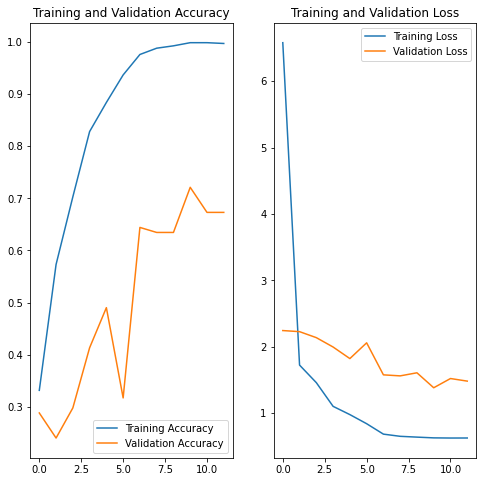

In [ ]:
#Visualising learning and loss over epoch
epochs=num_epochs
plot_history(history1) 

In [ ]:
tf.keras.backend.clear_session()

In [ ]:
#Though accuracy increased and loss is decreasing ,there is still overfitting in the model

#Model 5
###increasing images and layers in model
###Decay learning rate along with regularisation

In [ ]:
#Hyper Parameters
batch_size = 17
num_imges=5       #per_folder
num_epochs=12
input_shape=[num_imges,120,160,3]
print ("Batch_size=",batch_size,"\n   epochs =", num_epochs)

Batch_size= 17 
   epochs = 12


In [ ]:
#Training Model
model = Sequential()
model.add(Conv3D(32, kernel_size=(3, 3, 3), activation='relu', input_shape=input_shape,padding="same",kernel_regularizer=regularizers.l2(l=0.01)))
model.add(Conv3D(64, kernel_size=(2, 2, 2), activation='relu',padding="same",kernel_regularizer=regularizers.l2(l=0.01)))
model.add(BatchNormalization())
model.add(MaxPooling3D(pool_size=(2, 2, 2)))
model.add(Dropout(0.25))
model.add(Conv3D(128, kernel_size=(2, 2, 2), activation='relu',padding="same"))
model.add(MaxPooling3D(pool_size=(2, 2, 2),padding='same'))
model.add(Dropout(0.4))
model.add(Flatten())
model.add(Dense(256, activation='relu'))
model.add(Dense(5, activation='softmax') )

Now that you have written the model, the next step is to `compile` the model. When you print the `summary` of the model, you'll see the total number of parameters you have to train.

In [ ]:
#Optimising Model with loss function and other metrics
learning_rate_fn = tf.keras.optimizers.schedules.PolynomialDecay(
    0.1, #starter_learning_rate,
    700, #decay_steps,
    0.00001,#end_learning_rate,
    power=0.1) 
model.compile(optimizer=tf.keras.optimizers.Adadelta(learning_rate=learning_rate_fn),
              loss=tf.keras.losses.categorical_crossentropy,
              metrics=[tf.keras.metrics.CategoricalAccuracy()])
print (model.summary())

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv3d (Conv3D)             (None, 5, 120, 160, 32)   2624      
                                                                 
 conv3d_1 (Conv3D)           (None, 5, 120, 160, 64)   16448     
                                                                 
 batch_normalization (BatchN  (None, 5, 120, 160, 64)  256       
 ormalization)                                                   
                                                                 
 max_pooling3d (MaxPooling3D  (None, 2, 60, 80, 64)    0         
 )                                                               
                                                                 
 dropout (Dropout)           (None, 2, 60, 80, 64)     0         
                                                                 
 conv3d_2 (Conv3D)           (None, 2, 60, 80, 128)    6

Let us create the `train_generator` and the `val_generator` which will be used in `.fit_generator`.

In [ ]:
train_generator = generator(train_path, train_doc, batch_size,1)
val_generator = generator(test_path, val_doc, batch_size,1)

In [ ]:
if (num_train_sequences%batch_size) == 0:
    steps_per_epoch = int(num_train_sequences/batch_size)
else:
    steps_per_epoch = (num_train_sequences//batch_size) + 1

if (num_val_sequences%batch_size) == 0:
    validation_steps = int(num_val_sequences/batch_size)
else:
    validation_steps = (num_val_sequences//batch_size) + 1

In [ ]:
LR = ReduceLROnPlateau(monitor='val_loss', factor=0.2,patience=1, min_lr=0.0001)
callbacks_list = [LR]

In [ ]:
history2=model.fit(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1, 
                    validation_data=val_generator,#callbacks=callbacks_list,
                    validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)

Source path =  /content/drive/MyDrive/Project_data/Project_data/train ; batch size = 17
Epoch 1/12
39/39 [==============================] - 618s 16s/step - loss: 5.8853 - categorical_accuracy: 0.2308 - val_loss: 2.0790 - val_categorical_accuracy: 0.2451
Epoch 2/12
39/39 [==============================] - 31s 808ms/step - loss: 2.1392 - categorical_accuracy: 0.3002 - val_loss: 2.0879 - val_categorical_accuracy: 0.1569
Epoch 3/12
39/39 [==============================] - 27s 693ms/step - loss: 1.8833 - categorical_accuracy: 0.4042 - val_loss: 2.0386 - val_categorical_accuracy: 0.2941
Epoch 4/12
39/39 [==============================] - 27s 697ms/step - loss: 1.8045 - categorical_accuracy: 0.4630 - val_loss: 2.0225 - val_categorical_accuracy: 0.1961
Epoch 5/12
39/39 [==============================] - 27s 687ms/step - loss: 1.6704 - categorical_accuracy: 0.5113 - val_loss: 2.0093 - val_categorical_accuracy: 0.2941
Epoch 6/12
39/39 [==============================] - 27s 694ms/step - loss: 1.5

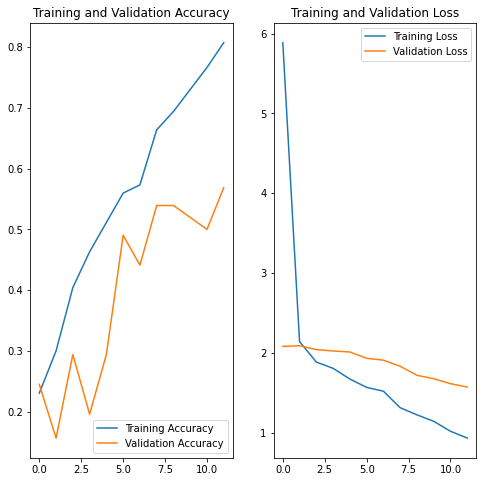

In [ ]:
#Visualising learning and loss over epoch
epochs=num_epochs
plot_history(history2) 

In [ ]:
tf.keras.backend.clear_session()

Increasing the data and batch size improved the result.
Now increasing the information to learn by adding layer and adjusting filter size

#Model 6
###increasing images and layers in model

In [10]:
#Hyper Parameters
batch_size = 13
num_imges=5
num_epochs=20
input_shape=[num_imges,120,160,3]
print ("Batch_size=",batch_size,"\n   epochs =", num_epochs)

Batch_size= 13 
   epochs = 20


In [11]:
#Training Model
model = Sequential()
model.add(Conv3D(32, kernel_size=(3, 3, 3), activation='relu', input_shape=input_shape,padding="same",kernel_regularizer=regularizers.l2(l=0.01)))
model.add(Conv3D(64, kernel_size=(2, 2, 2), activation='relu',padding="same",kernel_regularizer=regularizers.l2(l=0.01)))
model.add(BatchNormalization())
model.add(MaxPooling3D(pool_size=(2, 2, 2)))
model.add(Dropout(0.25))

model.add(Conv3D(128, kernel_size=(2, 2, 2), activation='relu',padding="same"))
model.add(MaxPooling3D(pool_size=(2, 2, 2),padding='same'))
model.add(Dropout(0.4))
model.add(Flatten())
model.add(Dense(256, activation='relu'))
model.add(Dense(5, activation='softmax') )

Now that you have written the model, the next step is to `compile` the model. When you print the `summary` of the model, you'll see the total number of parameters you have to train.

In [12]:
#Optimising Model with loss function and other metrics 
model.compile(optimizer=tf.keras.optimizers.Adadelta(learning_rate=0.1),
              loss=tf.keras.losses.categorical_crossentropy,
              metrics=[tf.keras.metrics.CategoricalAccuracy()])
print (model.summary())

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv3d (Conv3D)             (None, 5, 120, 160, 32)   2624      
                                                                 
 conv3d_1 (Conv3D)           (None, 5, 120, 160, 64)   16448     
                                                                 
 batch_normalization (BatchN  (None, 5, 120, 160, 64)  256       
 ormalization)                                                   
                                                                 
 max_pooling3d (MaxPooling3D  (None, 2, 60, 80, 64)    0         
 )                                                               
                                                                 
 dropout (Dropout)           (None, 2, 60, 80, 64)     0         
                                                                 
 conv3d_2 (Conv3D)           (None, 2, 60, 80, 128)    6

creating the `train_generator` and the `val_generator` 

In [13]:
train_generator = generator(train_path, train_doc, batch_size,1)
val_generator = generator(test_path, val_doc, batch_size,1)

In [14]:
if (num_train_sequences%batch_size) == 0:
    steps_per_epoch = int(num_train_sequences/batch_size)
else:
    steps_per_epoch = (num_train_sequences//batch_size) + 1

if (num_val_sequences%batch_size) == 0:
    validation_steps = int(num_val_sequences/batch_size)
else:
    validation_steps = (num_val_sequences//batch_size) + 1

In [15]:
LR = ReduceLROnPlateau(monitor='val_loss', factor=0.1,patience=1, min_lr=0.0001)
callbacks_list = [LR]

In [16]:
history2=model.fit(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1, 
                    validation_data=val_generator, callbacks=callbacks_list,
                    validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)

Source path =  /content/drive/MyDrive/Project_data/Project_data/train ; batch size = 13
Epoch 1/20
51/51 [==============================] - 1254s 25s/step - loss: 5.0302 - categorical_accuracy: 0.2640 - val_loss: 2.0738 - val_categorical_accuracy: 0.1538 - lr: 0.1000
Epoch 2/20
51/51 [==============================] - 29s 576ms/step - loss: 2.0257 - categorical_accuracy: 0.2640 - val_loss: 2.0416 - val_categorical_accuracy: 0.3750 - lr: 0.1000
Epoch 3/20
51/51 [==============================] - 22s 428ms/step - loss: 1.9257 - categorical_accuracy: 0.3394 - val_loss: 1.9984 - val_categorical_accuracy: 0.2981 - lr: 0.1000
Epoch 4/20
51/51 [==============================] - 21s 415ms/step - loss: 1.8143 - categorical_accuracy: 0.3922 - val_loss: 1.9599 - val_categorical_accuracy: 0.2981 - lr: 0.1000
Epoch 5/20
51/51 [==============================] - 21s 415ms/step - loss: 1.7308 - categorical_accuracy: 0.4585 - val_loss: 1.9297 - val_categorical_accuracy: 0.3365 - lr: 0.1000
Epoch 6/20
5

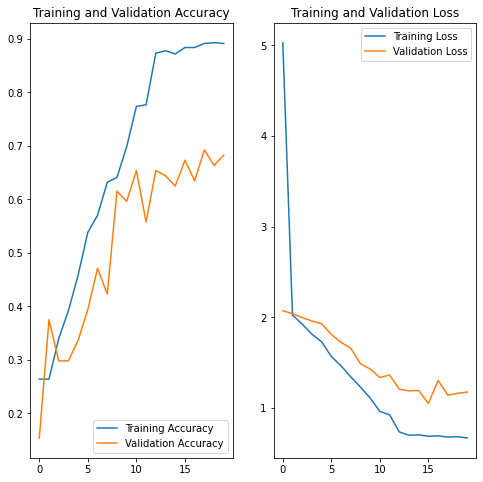

In [17]:
#Visualising learning and loss over epoch
epochs=num_epochs
plot_history(history2) 

In [18]:
tf.keras.backend.clear_session()

# Model 7
Smaller batch size and with polynomial decay in learning rate gave the best result in several combination of Conv3D we tried


In [ ]:
#Hyper Parameters
batch_size = 3
num_imges=5
num_epochs=20
input_shape=[num_imges,120,160,3]

In [ ]:
#Creating Model
model = Sequential()

model.add(Conv3D(32, kernel_size=(3, 3, 3), activation='relu', input_shape=input_shape,padding="same",kernel_regularizer=regularizers.l2(l=0.01)))
model.add(Conv3D(64, kernel_size=(2, 2, 2), activation='relu',padding="same",kernel_regularizer=regularizers.l2(l=0.01)))
model.add(BatchNormalization())
model.add(MaxPooling3D(pool_size=(2, 2, 2)))
model.add(Dropout(0.25))

model.add(Conv3D(128, kernel_size=(2, 2, 2), activation='relu',padding="same"))
model.add(MaxPooling3D(pool_size=(2, 2, 2),padding='same'))
model.add(Dropout(0.4))
model.add(Flatten())
model.add(Dense(256, activation='relu'))
model.add(Dense(5, activation='softmax') )

Now that you have written the model, the next step is to `compile` the model. When you print the `summary` of the model, you'll see the total number of parameters you have to train.

In [ ]:
#Optimising model
learning_rate_fn = tf.keras.optimizers.schedules.PolynomialDecay(
    0.1, #starter_learning_rate,
    1200, #decay_steps,
    0.00001,#end_learning_rate,
    power=0.1) 
model.compile(optimizer=tf.keras.optimizers.Adadelta(learning_rate=learning_rate_fn),
              loss=tf.keras.losses.categorical_crossentropy,
              metrics=[tf.keras.metrics.CategoricalAccuracy()])
print (model.summary())

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv3d_3 (Conv3D)           (None, 3, 120, 160, 32)   2624      
                                                                 
 conv3d_4 (Conv3D)           (None, 3, 120, 160, 64)   16448     
                                                                 
 batch_normalization_1 (Batc  (None, 3, 120, 160, 64)  256       
 hNormalization)                                                 
                                                                 
 max_pooling3d_2 (MaxPooling  (None, 1, 60, 80, 64)    0         
 3D)                                                             
                                                                 
 dropout_2 (Dropout)         (None, 1, 60, 80, 64)     0         
                                                                 
 conv3d_5 (Conv3D)           (None, 1, 60, 80, 128)   

Let us create the `train_generator` and the `val_generator` which will be used in `.fit_generator`.

In [ ]:
train_generator = generator(train_path, train_doc, batch_size)
val_generator = generator(test_path, val_doc, batch_size)

In [ ]:
os.environ['TF_FORCE_GPU_ALLOW_GROWTH'] = 'true'

In [ ]:
if (num_train_sequences%batch_size) == 0:
    steps_per_epoch = int(num_train_sequences/batch_size)
else:
    steps_per_epoch = (num_train_sequences//batch_size) + 1

if (num_val_sequences%batch_size) == 0:
    validation_steps = int(num_val_sequences/batch_size)
else:
    validation_steps = (num_val_sequences//batch_size) + 1

In [ ]:
history=model.fit(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1, 
                    validation_data=val_generator,
                    validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)

Source path =  /content/drive/MyDrive/Project_data/Project_data/train ; batch size = 3
Epoch 1/20
221/221 [==============================] - 874s 4s/step - loss: 2.4714 - categorical_accuracy: 0.2805 - val_loss: 1.9667 - val_categorical_accuracy: 0.3627
Epoch 2/20
221/221 [==============================] - 39s 179ms/step - loss: 1.6743 - categorical_accuracy: 0.4676 - val_loss: 1.7127 - val_categorical_accuracy: 0.5882
Epoch 3/20
221/221 [==============================] - 38s 173ms/step - loss: 1.3412 - categorical_accuracy: 0.6033 - val_loss: 1.3905 - val_categorical_accuracy: 0.6765
Epoch 4/20
221/221 [==============================] - 38s 173ms/step - loss: 1.0219 - categorical_accuracy: 0.7496 - val_loss: 1.3668 - val_categorical_accuracy: 0.5980
Epoch 5/20
221/221 [==============================] - 38s 173ms/step - loss: 0.9875 - categorical_accuracy: 0.7768 - val_loss: 1.2507 - val_categorical_accuracy: 0.7255
Epoch 6/20
221/221 [==============================] - 38s 173ms/step -

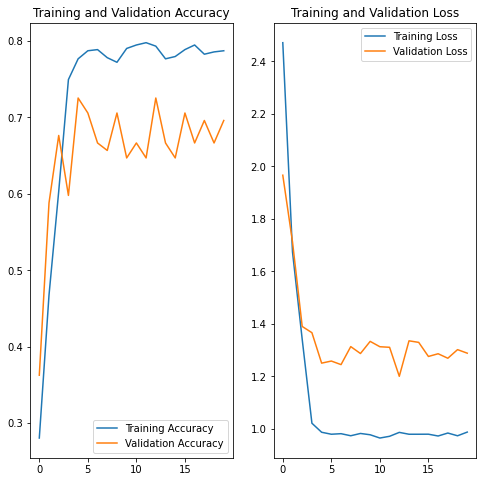

In [ ]:
#Visualising loss and accuracy
epochs=num_epochs 
plot_history(history) 

# Model 8
To check for divergence or convergence of above obtained result 
Checking on 30 epochs, and learning rate with ReduceOnPlateau instead polynomial decay

In [ ]:
#Hyper-Parameters
batch_size = 13
num_imges=3
num_epochs=30
input_shape=[num_imges,120,160,3]

In [ ]:
#Initialising model

model = Sequential()
model.add(Conv3D(32, kernel_size=(3, 3, 3), activation='relu', input_shape=input_shape,padding="same",))
model.add(Conv3D(64, kernel_size=(2, 2, 2), activation='relu',padding="same",kernel_regularizer=regularizers.l2(l=0.01)))
model.add(BatchNormalization())
model.add(MaxPooling3D(pool_size=(2, 2, 2))) 
model.add(Dropout(0.2))

model.add(Conv3D(128, kernel_size=(2, 2, 2), activation='relu',padding="same",kernel_regularizer=regularizers.l2(l=0.01)))
model.add(MaxPooling3D(pool_size=(2, 2, 2),padding='same'))
model.add(Dropout(0.4))
model.add(Flatten())
model.add(Dense(256, activation='relu'))
model.add(Dense(5, activation='softmax') )

In [ ]:
#Optimising model
model.compile(optimizer=tf.keras.optimizers.Adadelta(learning_rate=0.01),
              loss=tf.keras.losses.categorical_crossentropy,
              metrics=[tf.keras.metrics.CategoricalAccuracy()])
print (model.summary())

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv3d_3 (Conv3D)           (None, 3, 120, 160, 32)   2624      
                                                                 
 conv3d_4 (Conv3D)           (None, 3, 120, 160, 64)   16448     
                                                                 
 batch_normalization_1 (Batc  (None, 3, 120, 160, 64)  256       
 hNormalization)                                                 
                                                                 
 max_pooling3d_2 (MaxPooling  (None, 1, 60, 80, 64)    0         
 3D)                                                             
                                                                 
 dropout_2 (Dropout)         (None, 1, 60, 80, 64)     0         
                                                                 
 conv3d_5 (Conv3D)           (None, 1, 60, 80, 128)   

In [ ]:
#CReating generator iterator
train_generator = generator(train_path, train_doc, batch_size)
val_generator = generator(test_path, val_doc, batch_size)

In [ ]:
if (num_train_sequences%batch_size) == 0:
    steps_per_epoch = int(num_train_sequences/batch_size)
else:
    steps_per_epoch = (num_train_sequences//batch_size) + 1

if (num_val_sequences%batch_size) == 0:
    validation_steps = int(num_val_sequences/batch_size)
else:
    validation_steps = (num_val_sequences//batch_size) + 1

In [ ]:
###_callback
LR = ReduceLROnPlateau(monitor='val_loss', factor=0.1,patience=2, min_lr=0.0001)
callbacks_list = [LR]

In [ ]:
history=model.fit(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1, 
                    validation_data=val_generator, callbacks=callbacks_list,
                    validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)

Source path =  /content/drive/MyDrive/Project_data/Project_data/train ; batch size = 13
Epoch 1/30
51/51 [==============================] - 1147s 23s/step - loss: 3.0245 - categorical_accuracy: 0.2851 - val_loss: 2.8579 - val_categorical_accuracy: 0.2885 - lr: 0.0100
Epoch 2/30
51/51 [==============================] - 283s 6s/step - loss: 2.7140 - categorical_accuracy: 0.3756 - val_loss: 2.8462 - val_categorical_accuracy: 0.2404 - lr: 0.0100
Epoch 3/30
51/51 [==============================] - 295s 6s/step - loss: 2.4903 - categorical_accuracy: 0.4977 - val_loss: 2.8053 - val_categorical_accuracy: 0.2692 - lr: 0.0100
Epoch 4/30
51/51 [==============================] - 281s 6s/step - loss: 2.3196 - categorical_accuracy: 0.5958 - val_loss: 2.7743 - val_categorical_accuracy: 0.2981 - lr: 0.0100
Epoch 5/30
51/51 [==============================] - 279s 5s/step - loss: 2.2457 - categorical_accuracy: 0.6169 - val_loss: 2.6837 - val_categorical_accuracy: 0.4423 - lr: 0.0100
Epoch 6/30
51/51 [==

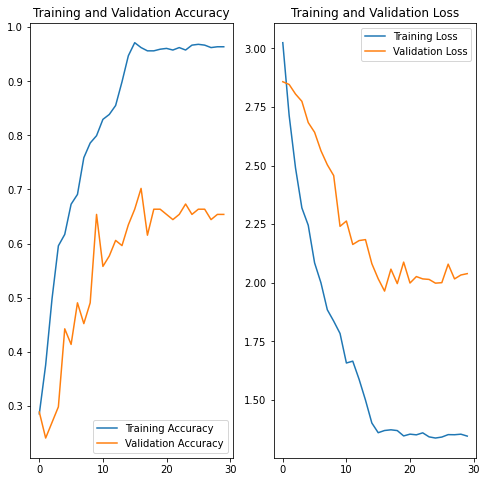

In [ ]:
epochs=num_epochs
plot_history(history) 
 

It seems around ~70 is easily achievable, we got 0.70+ in 7th model with minimum loss, using hyperparameters we used


#Trying CNN+LSTM Based Model

In [ ]:
#Hyperparameters
batch_size = 17
num_imges=3
num_epochs=15

## Model 9
using conv2d and lstm

In [ ]:
from keras.layers import Conv2D,Dense, GRU, Flatten, TimeDistributed, Flatten, BatchNormalization, Activation,Dropout
from keras.layers.convolutional import Conv3D, MaxPooling3D,MaxPooling2D
from keras.layers import LSTM


def model_skeleton(input_shape=input_shape):
     model = Sequential()
     # define CNN model
     model.add(TimeDistributed(Conv2D(32, kernel_size=(3, 3), activation='relu',padding="same",kernel_regularizer=regularizers.l2(l=0.01)),input_shape=input_shape))
     model.add(TimeDistributed(Conv2D(32, kernel_size=(2, 2), activation='relu',padding="same",kernel_regularizer=regularizers.l2(l=0.01))))
     model.add(TimeDistributed(MaxPooling2D(pool_size=(2, 2))))
     model.add(TimeDistributed(Flatten()))
     # define LSTM model
     model.add(LSTM(50,return_sequences=False,input_shape=(5,1,1)))
 #    model.add(TimeDistributed(Dropout(0.5)()))
     model.add(Dense(64, activation='relu'))
     model.add(Dense(5, activation='softmax') )
     return model
model=model_skeleton(input_shape)

Now that you have written the model, the next step is to `compile` the model. When you print the `summary` of the model, you'll see the total number of parameters you have to train.

In [ ]:
decay_steps=663*num_imges*num_epochs
learning_rate_fn = tf.keras.optimizers.schedules.PolynomialDecay(
    0.1, #starter_learning_rate,
    1500, #decay_steps,
    0.0001,#end_learning_rate,
    power=0.1) 
model.compile(optimizer=tf.keras.optimizers.Adadelta(learning_rate=0.1),
              loss=tf.keras.losses.categorical_crossentropy,
              metrics=[tf.keras.metrics.CategoricalAccuracy()])

model.build(input_shape) 
model.summary()

Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 time_distributed_29 (TimeDi  (None, 3, 120, 160, 32)  896       
 stributed)                                                      
                                                                 
 time_distributed_30 (TimeDi  (None, 3, 120, 160, 32)  4128      
 stributed)                                                      
                                                                 
 time_distributed_31 (TimeDi  (None, 3, 60, 80, 32)    0         
 stributed)                                                      
                                                                 
 time_distributed_32 (TimeDi  (None, 3, 153600)        0         
 stributed)                                                      
                                                                 
 lstm_7 (LSTM)               (None, 50)               

Let us create the `train_generator` and the `val_generator` which will be used in `.fit_generator`.

In [ ]:
train_generator = generator(train_path, train_doc, batch_size)
val_generator = generator(test_path, val_doc, batch_size)

In [ ]:
os.environ['TF_FORCE_GPU_ALLOW_GROWTH'] = 'true'

In [ ]:
if (num_train_sequences%batch_size) == 0:
    steps_per_epoch = int(num_train_sequences/batch_size)
else:
    steps_per_epoch = (num_train_sequences//batch_size) + 1

if (num_val_sequences%batch_size) == 0:
    validation_steps = int(num_val_sequences/batch_size)
else:
    validation_steps = (num_val_sequences//batch_size) + 1

In [ ]:
###_callback
model_name = '10img_20epoch_00' + '_' + str(curr_dt_time).replace(' ','').replace(':','_') + '/'
if not os.path.exists(model_name):
    os.mkdir(model_name)        
filepath = model_name + "metric:{loss:.5f}-{categorical_accuracy:.5f}-{val_loss:.5f}-{val_categorical_accuracy:.5f}.h5"
checkpoint = ModelCheckpoint(filepath,monitor='val_loss', verbose=1, save_best_only=True, save_weights_only=True, mode='auto', save_freq="epoch")
LR = ReduceLROnPlateau(monitor='val_loss', factor=0.1,
                              patience=2, min_lr=0.0001)
callbacks_list = [checkpoint,LR]


In [ ]:
history=model.fit(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1, 
                    validation_data=val_generator, callbacks=callbacks_list,
                    validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)

Source path =  /content/drive/MyDrive/Project_data/Project_data/train ; batch size = 17
Epoch 1/15
39/39 [==============================] - ETA: 0s - loss: 1.9848 - categorical_accuracy: 0.2232 Source path =  /content/drive/MyDrive/Project_data/Project_data/val ; batch size = 17

Epoch 00001: val_loss improved from inf to 1.94359, saving model to 10img_20epoch_00_2022-02-0217_37_59.182936/metric:1.98484-0.22323-1.94359-0.22549.h5
39/39 [==============================] - 1580s 41s/step - loss: 1.9848 - categorical_accuracy: 0.2232 - val_loss: 1.9436 - val_categorical_accuracy: 0.2255 - lr: 0.1000
Epoch 2/15
39/39 [==============================] - ETA: 0s - loss: 1.9211 - categorical_accuracy: 0.2821
Epoch 00002: val_loss improved from 1.94359 to 1.89953, saving model to 10img_20epoch_00_2022-02-0217_37_59.182936/metric:1.92112-0.28205-1.89953-0.27451.h5
39/39 [==============================] - 99s 3s/step - loss: 1.9211 - categorical_accuracy: 0.2821 - val_loss: 1.8995 - val_categorica

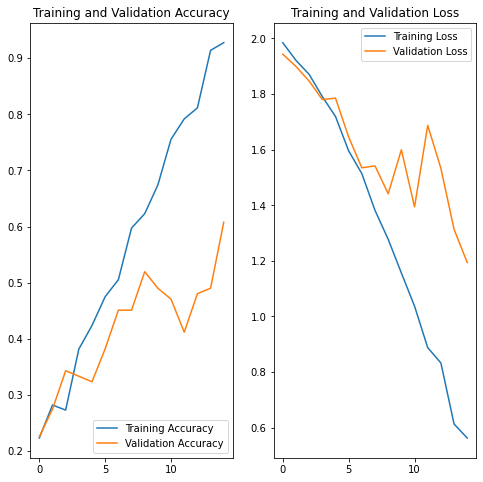

In [ ]:
epochs=num_epochs
plot_history(history) 
 

## Model 10
using conv2d and lstm :Removing overfitting as seen in previous model

In [33]:

def model_skeleton(input_shape=input_shape):
     model = Sequential()
     # define CNN model
     model.add(TimeDistributed(Conv2D(32, kernel_size=(3, 3), activation='relu',padding="same",kernel_regularizer=regularizers.l2(l=0.001)),input_shape=input_shape))
     model.add(TimeDistributed(Conv2D(32, kernel_size=(2, 2), activation='relu',padding="same",kernel_regularizer=regularizers.l2(l=0.001))))
     model.add(TimeDistributed(MaxPooling2D(pool_size=(3, 3))))
     model.add(TimeDistributed(Dropout(0.3)))
     model.add(TimeDistributed(Conv2D(64, kernel_size=(3, 3), activation='relu',padding="same",kernel_regularizer=regularizers.l2(l=0.001)),input_shape=input_shape))
     model.add(TimeDistributed(Conv2D(128, kernel_size=(2, 2), activation='relu',padding="same",kernel_regularizer=regularizers.l2(l=0.01))))
     model.add(TimeDistributed(MaxPooling2D(pool_size=(3, 3))))
     model.add(TimeDistributed(Dropout(0.3)))
     model.add(TimeDistributed(Flatten()))
     # define LSTM model
     model.add(LSTM(100,return_sequences=False,input_shape=(5,1,1),  recurrent_regularizer=regularizers.l2(0.01),activity_regularizer=regularizers.l2(0.01)))
     model.add(Dense(128, activation='relu'))
     model.add(Dense(5, activation='softmax') )
     return model
model=model_skeleton(input_shape)

Now that you have written the model, the next step is to `compile` the model. When you print the `summary` of the model, you'll see the total number of parameters you have to train.

In [34]:
decay_steps=663*num_imges*num_epochs
learning_rate_fn = tf.keras.optimizers.schedules.PolynomialDecay(
    0.1, #starter_learning_rate,
    1500, #decay_steps,
    0.0001,#end_learning_rate,
    power=0.1) 
model.compile(optimizer=tf.keras.optimizers.Adadelta(learning_rate=0.01),
              loss=tf.keras.losses.categorical_crossentropy,
              metrics=[tf.keras.metrics.CategoricalAccuracy()])

model.build(input_shape) 
model.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 time_distributed_22 (TimeDi  (None, 5, 120, 160, 32)  896       
 stributed)                                                      
                                                                 
 time_distributed_23 (TimeDi  (None, 5, 120, 160, 32)  4128      
 stributed)                                                      
                                                                 
 time_distributed_24 (TimeDi  (None, 5, 40, 53, 32)    0         
 stributed)                                                      
                                                                 
 time_distributed_25 (TimeDi  (None, 5, 40, 53, 32)    0         
 stributed)                                                      
                                                                 
 time_distributed_26 (TimeDi  (None, 5, 40, 53, 64)   

Let us create the `train_generator` and the `val_generator` which will be used in `.fit_generator`.

In [35]:
train_generator = generator(train_path, train_doc, batch_size,1)
val_generator = generator(test_path, val_doc, batch_size,1)

In [36]:
os.environ['TF_FORCE_GPU_ALLOW_GROWTH'] = 'true'

In [37]:
if (num_train_sequences%batch_size) == 0:
    steps_per_epoch = int(num_train_sequences/batch_size)
else:
    steps_per_epoch = (num_train_sequences//batch_size) + 1

if (num_val_sequences%batch_size) == 0:
    validation_steps = int(num_val_sequences/batch_size)
else:
    validation_steps = (num_val_sequences//batch_size) + 1

In [38]:
###_callback
model_name = '10img_20epoch_00' + '_' + str(curr_dt_time).replace(' ','').replace(':','_') + '/'
if not os.path.exists(model_name):
    os.mkdir(model_name)        
filepath = model_name + "metric:{loss:.5f}-{categorical_accuracy:.5f}-{val_loss:.5f}-{val_categorical_accuracy:.5f}.h5"
checkpoint = ModelCheckpoint(filepath,monitor='val_loss', verbose=1, save_best_only=True, save_weights_only=True, mode='auto', save_freq="epoch")
LR = ReduceLROnPlateau(monitor='val_loss', factor=0.1,
                              patience=2, min_lr=0.0001)
callbacks_list = [checkpoint,LR]


In [39]:
history=model.fit(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1, 
                    validation_data=val_generator, callbacks=callbacks_list,
                    validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)

Source path =  /content/drive/MyDrive/Project_data/Project_data/train ; batch size = 13
Epoch 1/20
51/51 [==============================] - ETA: 0s - loss: 3.5334 - categorical_accuracy: 0.2112 Source path =  /content/drive/MyDrive/Project_data/Project_data/val ; batch size = 13

Epoch 1: val_loss improved from inf to 3.51105, saving model to 10img_20epoch_00_2022-06-0119_45_11.251181/metric:3.53343-0.21116-3.51105-0.23077.h5
51/51 [==============================] - 885s 18s/step - loss: 3.5334 - categorical_accuracy: 0.2112 - val_loss: 3.5111 - val_categorical_accuracy: 0.2308 - lr: 0.0100
Epoch 2/20
51/51 [==============================] - ETA: 0s - loss: 3.5041 - categorical_accuracy: 0.2172
Epoch 2: val_loss improved from 3.51105 to 3.48704, saving model to 10img_20epoch_00_2022-06-0119_45_11.251181/metric:3.50406-0.21719-3.48704-0.19231.h5
51/51 [==============================] - 26s 521ms/step - loss: 3.5041 - categorical_accuracy: 0.2172 - val_loss: 3.4870 - val_categorical_accu

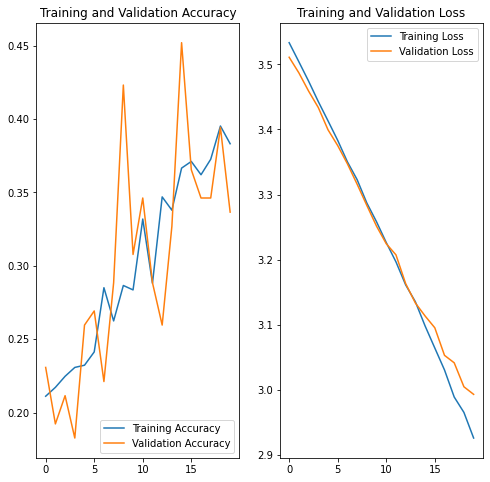

In [40]:
epochs=num_epochs
plot_history(history) 
 

########seems we over_regularized and hence underfitting

## Model
using conv2d and lstm :Removing overfitting as seen in previous model

In [64]:
#Hyperparameters
batch_size = 39
num_imges=5
num_epochs=100
def model_skeleton(input_shape=input_shape):
     model = Sequential()
     # define CNN model
     model.add(TimeDistributed(Conv2D(32, kernel_size=(3, 3), activation='relu',padding="same",kernel_regularizer=regularizers.l2(l=0.001)),input_shape=input_shape))
     model.add(TimeDistributed(Conv2D(32, kernel_size=(2, 2), activation='relu',padding="same",kernel_regularizer=regularizers.l2(l=0.001))))
     model.add(TimeDistributed(MaxPooling2D(pool_size=(3, 3))))
     model.add(TimeDistributed(Dropout(0.25)))
     model.add(TimeDistributed(Conv2D(64, kernel_size=(3, 3), activation='relu',padding="same",kernel_regularizer=regularizers.l2(l=0.001)),input_shape=input_shape))
     model.add(TimeDistributed(Conv2D(128, kernel_size=(2, 2), activation='relu',padding="same",kernel_regularizer=regularizers.l2(l=0.001))))
     model.add(TimeDistributed(MaxPooling2D(pool_size=(3, 3))))
     model.add(TimeDistributed(Dropout(0.3)))
     model.add(TimeDistributed(Flatten()))
     # define LSTM model
     model.add(LSTM(100,return_sequences=False,input_shape=(5,1,1)))
     model.add(Dense(128, activation='relu'))
     model.add(Dense(5, activation='softmax') )
     return model
model=model_skeleton(input_shape)

Now that you have written the model, the next step is to `compile` the model. When you print the `summary` of the model, you'll see the total number of parameters you have to train.

In [65]:
decay_steps=663*num_imges*num_epochs

model.compile(optimizer=tf.keras.optimizers.Adadelta(learning_rate=0.1),
              loss=tf.keras.losses.categorical_crossentropy,
              metrics=[tf.keras.metrics.CategoricalAccuracy()])

model.build(input_shape) 
model.summary()

Model: "sequential_9"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 time_distributed_58 (TimeDi  (None, 5, 120, 160, 32)  896       
 stributed)                                                      
                                                                 
 time_distributed_59 (TimeDi  (None, 5, 120, 160, 32)  4128      
 stributed)                                                      
                                                                 
 time_distributed_60 (TimeDi  (None, 5, 40, 53, 32)    0         
 stributed)                                                      
                                                                 
 time_distributed_61 (TimeDi  (None, 5, 40, 53, 32)    0         
 stributed)                                                      
                                                                 
 time_distributed_62 (TimeDi  (None, 5, 40, 53, 64)   

Let us create the `train_generator` and the `val_generator` which will be used in `.fit_generator`.

In [66]:
train_generator = generator(train_path, train_doc, batch_size,1)
val_generator = generator(test_path, val_doc, batch_size,1)

In [67]:
os.environ['TF_FORCE_GPU_ALLOW_GROWTH'] = 'true'

In [68]:
if (num_train_sequences%batch_size) == 0:
    steps_per_epoch = int(num_train_sequences/batch_size)
else:
    steps_per_epoch = (num_train_sequences//batch_size) + 1

if (num_val_sequences%batch_size) == 0:
    validation_steps = int(num_val_sequences/batch_size)
else:
    validation_steps = (num_val_sequences//batch_size) + 1

In [69]:
###_callback
model_name = '10img_20epoch_00' + '_' + str(curr_dt_time).replace(' ','').replace(':','_') + '/'
if not os.path.exists(model_name):
    os.mkdir(model_name)        
filepath = model_name + "metric:{loss:.5f}-{categorical_accuracy:.5f}-{val_loss:.5f}-{val_categorical_accuracy:.5f}.h5"
checkpoint = ModelCheckpoint(filepath,monitor='val_loss', verbose=1, save_best_only=True, save_weights_only=True, mode='auto', save_freq="epoch")
LR = ReduceLROnPlateau(monitor='val_loss', factor=0.1,
                              patience=2, min_lr=0.0001)
callbacks_list = [checkpoint,LR]


In [70]:
history=model.fit(train_generator, steps_per_epoch=steps_per_epoch, epochs=100, verbose=1, 
                    validation_data=val_generator, callbacks=callbacks_list,
                    validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)

Source path =  /content/drive/MyDrive/Project_data/Project_data/train ; batch size = 39
Epoch 1/100
17/17 [==============================] - ETA: 0s - loss: 1.7826 - categorical_accuracy: 0.1780 Source path =  /content/drive/MyDrive/Project_data/Project_data/val ; batch size = 39

Epoch 1: val_loss improved from inf to 1.77008, saving model to 10img_20epoch_00_2022-06-0119_45_11.251181/metric:1.78261-0.17798-1.77008-0.17949.h5
17/17 [==============================] - 433s 20s/step - loss: 1.7826 - categorical_accuracy: 0.1780 - val_loss: 1.7701 - val_categorical_accuracy: 0.1795 - lr: 0.1000
Epoch 2/100
17/17 [==============================] - ETA: 0s - loss: 1.7713 - categorical_accuracy: 0.2157
Epoch 2: val_loss improved from 1.77008 to 1.75455, saving model to 10img_20epoch_00_2022-06-0119_45_11.251181/metric:1.77127-0.21569-1.75455-0.23932.h5
17/17 [==============================] - 18s 1s/step - loss: 1.7713 - categorical_accuracy: 0.2157 - val_loss: 1.7545 - val_categorical_accur

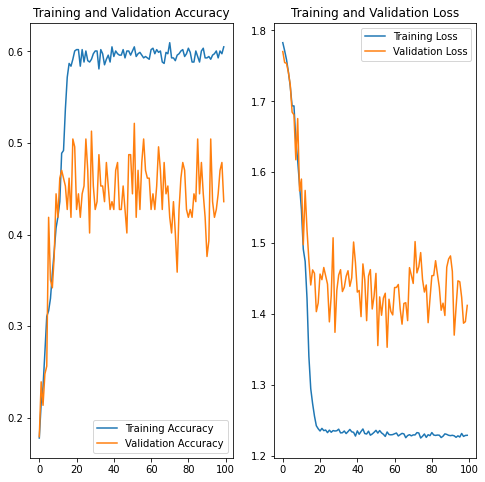

In [71]:
epochs=num_epochs
plot_history(history) 
 